In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn
import xgboost

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/as/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def get_NWRMSLE(predicted_l, actual_l, weights_l):
    p_ = np.array(predicted_l)
    a_ = np.array(actual_l)
    ret_val = np.sqrt(np.sum((weights_l*np.log(p_+1)-np.log(a_+1))**2)/sum(weights_l))
    return ret_val

def to_log(arr):
    arr_ = np.array(arr)
    return np.log(arr_+1)

def from_log(arr):
    arr_ = np.array(arr)
    return np.exp(arr_)-1

In [5]:
root_path = '/home/as/Desktop/machine learning/___kaggle/CorporacionFavorita'

In [6]:
test_df = pd.read_csv(root_path+'/data/test.csv', parse_dates=['date'],index_col='id')

### Process all stores

In [20]:
%%time

test_df['unit_sales'] = 0
scores_ = []
perc_thrA = 1
perc_thrB = 90

for store_id in range(1,55):
    print('processing store: ',store_id)
    
    #get training data
    print('\t - prepare training data...')
    td_s_exp = pd.read_csv(root_path+'/data/train_slices4/train_slice_store'+str(store_id)+'.csv.gz', 
                           parse_dates=['date'],compression='gzip')
    td_s_exp.rename(columns={'int'+str(store_id):'int_units'},inplace=True)
    td_s_exp.drop(['id'],axis=1,inplace=True)
    items_ = td_s_exp['item_nbr'].unique()
        #remove outbursts and add means
    print(' - before dropout:',len(td_s_exp))
    td_s_exp['to_drop'] = 0
    td_s_exp['mean_sales'] = 0
    #for dw_ in range(7):
    #    td_s_exp['mean_sales_d'+str(dw_)] = 0
    for i_ in items_:
        thrA_ = np.percentile(td_s_exp[td_s_exp['item_nbr']==i_]['unit_sales'],perc_thrA)
        thrB_ = np.percentile(td_s_exp[td_s_exp['item_nbr']==i_]['unit_sales'],perc_thrB)
        td_s_exp.loc[(td_s_exp['item_nbr']==i_)&((td_s_exp['unit_sales']<=thrA_)|(td_s_exp['unit_sales']>=thrB_)),['to_drop']] = 1
        td_s_exp.loc[(td_s_exp['item_nbr']==i_),['mean_sales']] = mean(td_s_exp[td_s_exp['item_nbr']==i_]['unit_sales'])
        #for dw_ in range(7):
        #    thr_ = np.percentile(td_s_exp[(td_s_exp['item_nbr']==i_)&(td_s_exp['dayofweek']==dw_)]['unit_sales'],perc_thr)
        #    td_s_exp.loc[(td_s_exp['item_nbr']==i_)&(td_s_exp['dayofweek']==dw_)&(td_s_exp['unit_sales']>thr_),['to_drop']] = 1
        #    td_s_exp.loc[(td_s_exp['item_nbr']==i_),['mean_sales_d'+str(dw_)]] = \
        #            mean(td_s_exp[(td_s_exp['item_nbr']==i_)&(td_s_exp['dayofweek']==dw_)]['unit_sales'])
    td_s_exp = td_s_exp[td_s_exp['to_drop']==0]
    td_s_exp.drop(['to_drop'],axis=1,inplace=True)
    print(' - after dropout:',len(td_s_exp))
    hcols = ['transNational','typeNational_ref','descrNational_ref','transRegional','typeRegional_ref',
     'descrRegional_ref','transLocal','typeLocal_ref','descrLocal_ref','transEvent','typeEvent_ref','descrEvent_ref']
        #prepare training slices
    working_slice = td_s_exp[(td_s_exp['unit_sales']>0) & (td_s_exp['date']>='2016-08-01')]

    del td_s_exp
    
    X_data = np.array(working_slice.drop(['store_nbr','date','unit_sales'],axis=1))
    y_data = np.array(working_slice['unit_sales'])
    print(' - X_data shape:',X_data.shape)
    #weights for correct NWRSMLE estimation - 1 for 0 (non-perishables) and 1.25 for 1 (perishables)
    weights_l_data = [(1+0.25*v_) for v_ in working_slice['perishable']]
    
    #train the algorithm
    print('\t - training...')
    xgb_r = xgboost.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.03, reg_lambda=1.0, reg_alpha=0.0,
                             subsample=0.9, colsample_bytree=0.7, min_child_weight=5)
    xgb_r.fit(X_data,to_log(y_data))
    y_xgb_predicted = from_log(xgb_r.predict(X_data))
    #rounding - try different methods - floor seems to yield best results
    y_xgb_predicted = np.round(y_xgb_predicted)
    scores_.append(get_NWRMSLE(y_xgb_predicted,y_data,weights_l_data))
    print('\t - xgboost NWRMSLE score:',scores_[-1:])
    regressor_ = xgb_r
    
    del X_data, y_data, weights_l_data, y_xgb_predicted
    
    working_slice_test = pd.read_csv(root_path+'/data/test_slices/test_slice_'+str(store_id)+'.csv',index_col='Unnamed: 0')
    working_slice_test.drop(['outs'+str(sn_) for sn_ in range(1,55,1)],axis=1,inplace=True)
    working_slice_test.drop(['int'+str(sn_) for sn_ in range(1,55,1) if sn_!=store_id+100],axis=1,inplace=True)
    working_slice_test.drop(hcols,axis=1,inplace=True)
    working_slice_test.drop(['cluster','city_ref','state_ref','store_type_ref'],axis=1,inplace=True)
    #working_slice_test.drop(['id2'],axis=1,inplace=True)
    working_slice_test['mean_sales'] = 0
    cols = ['id2']+list(working_slice.keys())
    working_slice_test = working_slice_test[cols]
    for i_ in working_slice['item_nbr'].unique():
        working_slice_test.loc[working_slice_test['item_nbr']==i_,['mean_sales']] = \
                      working_slice.loc[working_slice['item_nbr']==i_,['mean_sales']]
           
    del working_slice
    
    #working_slice_test2 = working_slice_test[working_slice_test['item_nbr'].isin(train_item_list)]
    X_data_test = np.array(working_slice_test.drop(['id2','store_nbr','date','unit_sales'],axis=1))
    print('\t - X_data_test: ',X_data_test.shape)
    
    #build forecast
    print('\t - building forecast...')
    y_test_predicted = from_log(regressor_.predict(X_data_test))
    y_test_predicted = np.round(y_test_predicted)
    
    test_df.loc[test_df.index.isin(working_slice_test['id2']),['unit_sales']] = np.reshape(y_test_predicted,(len(y_test_predicted),1))
    
    #cleaning up
    del xgb_r,regressor_,X_data_test,y_test_predicted,working_slice_test
    
test_df.to_csv(root_path+'/data/_test_df_processed_20171214_xgb2.csv')

processing store:  1
	 - prepare training data...
 - before dropout: 741707
 - after dropout: 448780
 - X_data shape: (448779, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.42491663066080576]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  2
	 - prepare training data...
 - before dropout: 869774
 - after dropout: 591722
 - X_data shape: (591722, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.43643325899540586]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  3
	 - prepare training data...
 - before dropout: 1014746
 - after dropout: 773784
 - X_data shape: (773784, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.51002975759079339]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  4
	 - prepare training data...
 - before dropout: 821600
 - after dropout: 546490
 - X_data shape: (546490, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.43014796619484774]
	 - X_data_test:  (62416, 10)
	 - building forecas

	 - xgboost NWRMSLE score: [0.42276919638315752]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  34
	 - prepare training data...
 - before dropout: 672254
 - after dropout: 419462
 - X_data shape: (419462, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.42006102972109244]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  35
	 - prepare training data...
 - before dropout: 408834
 - after dropout: 216587
 - X_data shape: (216587, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.40666536216410315]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  36
	 - prepare training data...
 - before dropout: 687891
 - after dropout: 437304
 - X_data shape: (437304, 10)
	 - training...
	 - xgboost NWRMSLE score: [0.43823435708874786]
	 - X_data_test:  (62416, 10)
	 - building forecast...
processing store:  37
	 - prepare training data...
 - before dropout: 823477
 - after dropout: 536154
 - X_data shape: (536154, 10)
	 - trai

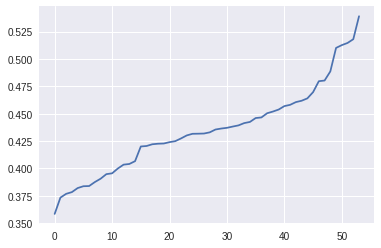

In [21]:
plot(sorted(scores_))

**Submission to kaggle**

In [22]:
test_df['unit_sales'].to_csv(root_path+'/data/_submission.csv',header=True,index_label='id')

In [23]:
test_df['unit_sales'].describe()

count    3.370464e+06
mean     1.112879e+00
std      3.566447e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      5.900000e+01
Name: unit_sales, dtype: float64